In [18]:
import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
from unittest import TestCase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

import warnings
warnings.filterwarnings('ignore')

In [19]:
# Set up data:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

# Initialise project:
project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_omx")
matrix.computational_view()

# Extra data specific to ODME:
index = car_graph.nodes_to_indices
dims = matrix.matrix_view.shape
count_vol_cols = ["class", "link_id", "direction", "obs_volume"]

# Initial assignment parameters:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5
assignment.set_algorithm("msa")

In [20]:
# Get original flows:.
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
# SQUISH EXTRA DIMENSION FOR NOW - DEAL WITH THIS PROPERLY LATER ON!!!
matrix.matrix_view = np.squeeze(matrix.matrix_view, axis=2)

# Set the observed count volumes:
flow = lambda i: assign_df.loc[assign_df["link_id"] == i, "matrix_ab"].values[0]
#links = [1, 20, 30, 40, 60, 70]
links = [10, 40, 70]
data=[["car", link, 1, flow(link)] for link in links]
count_volumes = pd.DataFrame(
    data=data,
    columns=count_vol_cols
)

# Store original matrix
original_demand = np.copy(matrix.matrix_view)

# Perturb original matrix:
np.random.seed(0)
perturbation = 3
perturbation_matrix = np.random.uniform(1 - perturbation/100, 1 + perturbation/100, size=dims)
new_matrix = np.round(matrix.matrix_view * perturbation_matrix)

In [21]:
all_odme=[]
# Perform ODME:
for alpha in range(1, 11):
    matrix.matrix_view = np.copy(new_matrix)

    all_odme.append(ODME(assignment,
        count_volumes,
        stop_crit=(25, 80, 0.001, 0.001),
        alpha=(alpha**2)/100,
        algorithm="reg_spiess"))
    all_odme[alpha-1].execute()
    print(f"ODME run {alpha} complete")

ODME run 1 complete
ODME run 2 complete
ODME run 3 complete
ODME run 4 complete
ODME run 5 complete
ODME run 6 complete
ODME run 7 complete
ODME run 8 complete
ODME run 9 complete
ODME run 10 complete


In [22]:
stats = [odme.get_all_statistics() for odme in all_odme]
total_iter_outers = [stat[stat["Inner Loop #"] == 0]["Total Iteration #"] for stat in stats]

Text(0.5, 1.0, 'Perturbed Sioux Falls Matrix\n 5 Count Volumes Given')

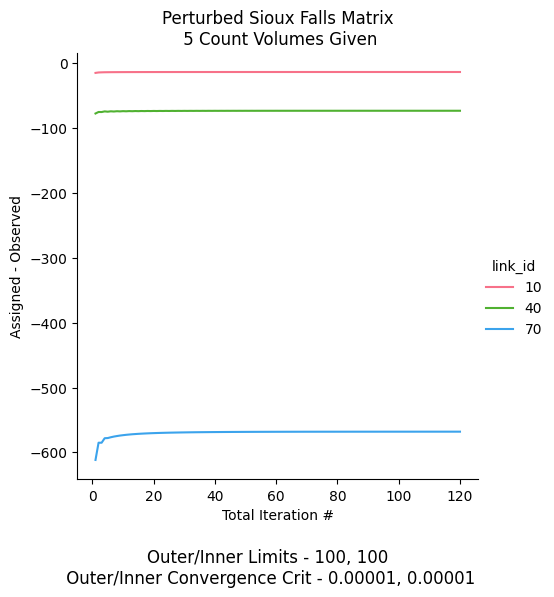

In [23]:
palette = automated_palette = sns.color_palette("husl", len(links))
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats[0], 
    palette=palette,
    markers=True, 
    dashes=False)

fig_size = plt.gcf().get_size_inches()
plt.figtext(0.5, -0.3 / fig_size[1],
    "Outer/Inner Limits - 100, 100\n Outer/Inner Convergence Crit - 0.00001, 0.00001", 
    ha='center', va='center', fontsize=12, color='black')
plt.title("Perturbed Sioux Falls Matrix\n 5 Count Volumes Given")

# for i in total_iter_outers:
#     plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)

Text(0.5, 1.0, 'Perturbed Sioux Falls Matrix\n 5 Count Volumes Given')

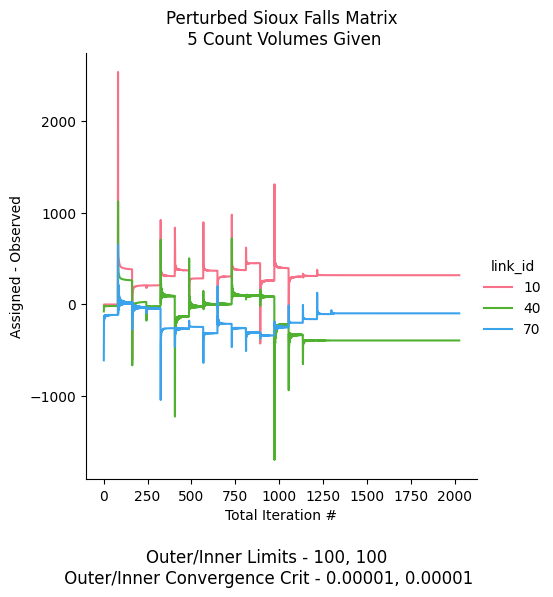

In [24]:
palette = automated_palette = sns.color_palette("husl", len(links))
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats[5], 
    palette=palette,
    markers=True, 
    dashes=False)

fig_size = plt.gcf().get_size_inches()
plt.figtext(0.5, -0.3 / fig_size[1],
    "Outer/Inner Limits - 100, 100\n Outer/Inner Convergence Crit - 0.00001, 0.00001", 
    ha='center', va='center', fontsize=12, color='black')
plt.title("Perturbed Sioux Falls Matrix\n 5 Count Volumes Given")

# for i in total_iter_outers:
#     plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)

Text(0.5, 1.0, 'Perturbed Sioux Falls Matrix\n 5 Count Volumes Given')

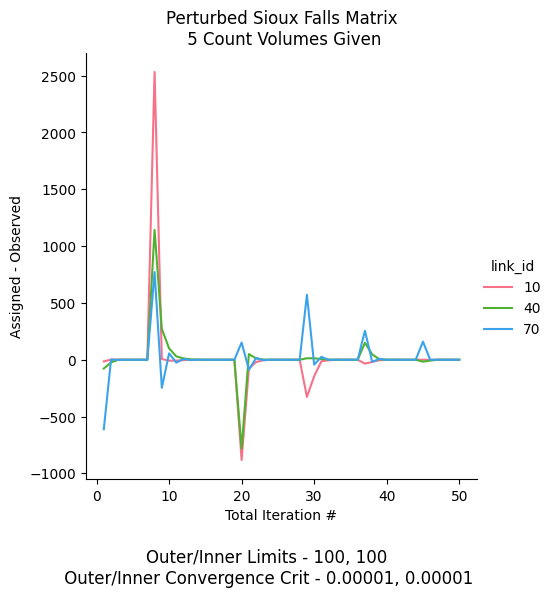

In [25]:
palette = automated_palette = sns.color_palette("husl", len(links))
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats[9], 
    palette=palette,
    markers=True, 
    dashes=False)

fig_size = plt.gcf().get_size_inches()
plt.figtext(0.5, -0.3 / fig_size[1],
    "Outer/Inner Limits - 100, 100\n Outer/Inner Convergence Crit - 0.00001, 0.00001", 
    ha='center', va='center', fontsize=12, color='black')
plt.title("Perturbed Sioux Falls Matrix\n 5 Count Volumes Given")

# for i in total_iter_outers:
#     plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)

In [26]:
all_cumulative = [odme.get_cumulative_factors() for odme in all_odme]

In [27]:
all_factors = pd.concat([factors.describe() for factors in all_cumulative], axis = 1).transpose().reset_index(drop=True)
all_factors["alpha"] = ((all_factors.index + 1)**2) / 100
all_factors

,count,mean,std,min,25%,50%,75%,max,alpha
0,576.0,1.000605,0.002736,1.000000e+00,1.0,1.0,1.0,1.034900,0.01
1,576.0,1.002252,0.010424,1.000000e+00,1.0,1.0,1.0,1.133121,0.04
2,576.0,0.995513,0.052873,5.071420e-01,1.0,1.0,1.0,1.387132,0.09
3,576.0,1.010535,0.121076,7.571875e-03,1.0,1.0,1.0,1.843053,0.16
4,576.0,0.994557,0.098057,3.650575e-07,1.0,1.0,1.0,1.738092,0.25
5,576.0,1.013937,0.191031,4.677301e-10,1.0,1.0,1.0,2.813633,0.36
6,576.0,1.022951,0.223920,5.341865e-06,1.0,1.0,1.0,3.075967,0.49
7,576.0,0.983218,0.137421,3.947985e-13,1.0,1.0,1.0,1.995801,0.64
8,576.0,1.030540,0.249867,2.620993e-05,1.0,1.0,1.0,3.134591,0.81
9,576.0,0.984461,0.040586,7.580250e-01,1.0,1.0,1.0,1.076843,1.00


<Axes: xlabel='alpha', ylabel='mean'>

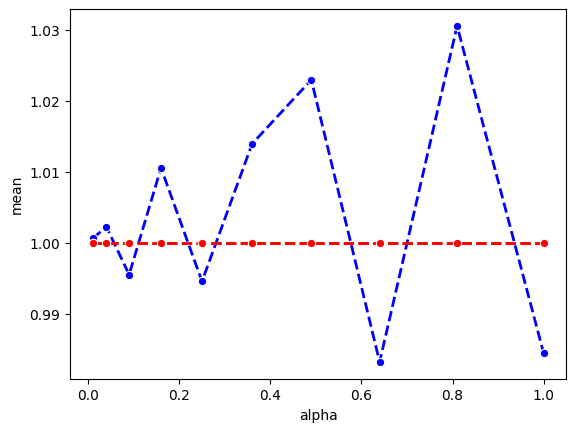

In [28]:
sns.lineplot(x='alpha', y='mean', data=all_factors, marker='o', color='blue', linestyle='--', linewidth=2)
sns.lineplot(x='alpha', y='75%', data=all_factors, marker='o', color='red', linestyle='--', linewidth=2)
sns.lineplot(x='alpha', y='25%', data=all_factors, marker='o', color='red', linestyle='--', linewidth=2)

<Axes: xlabel='alpha', ylabel='std'>

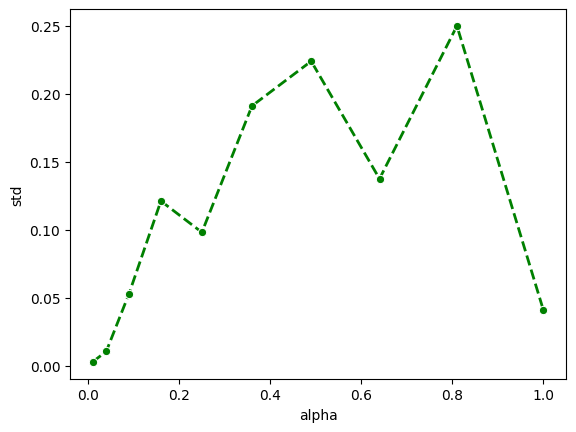

In [29]:
sns.lineplot(x='alpha', y='std', data=all_factors, marker='o', color='green', linestyle='--', linewidth=2)

<Axes: xlabel='Factors', ylabel='Count'>

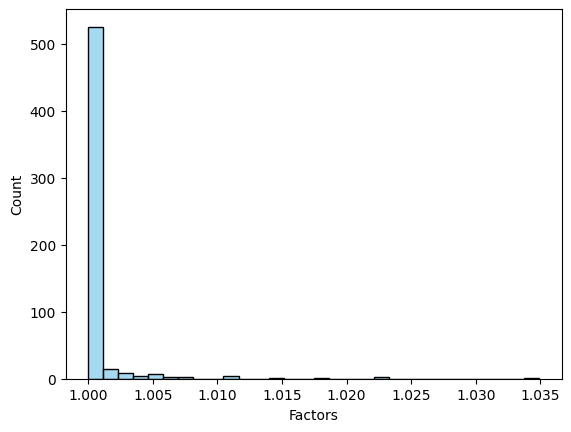

In [30]:
sns.histplot(all_cumulative[0]['Factors'], bins=30, kde=False, color='skyblue')

<Axes: xlabel='Factors', ylabel='Count'>

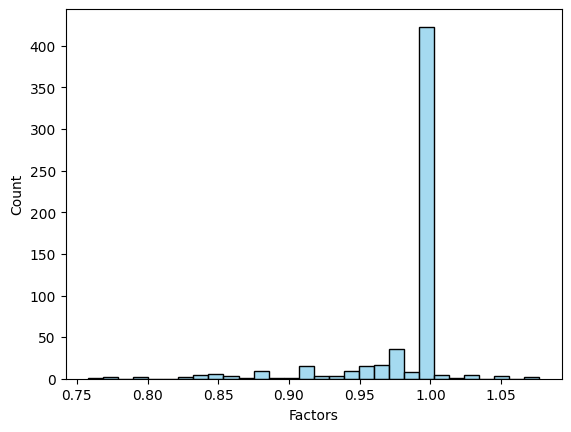

In [31]:
sns.histplot(all_cumulative[9]['Factors'], bins=30, kde=False, color='skyblue')

In [32]:
factors_diff = all_cumulative[0]["Factors"] - all_cumulative[9]["Factors"]

In [33]:
factors_diff.describe()

count    576.000000
mean       0.016144
std        0.041638
min       -0.076843
25%        0.000000
50%        0.000000
75%        0.000000
max        0.242311
Name: Factors, dtype: float64

<Axes: xlabel='Factors', ylabel='Count'>

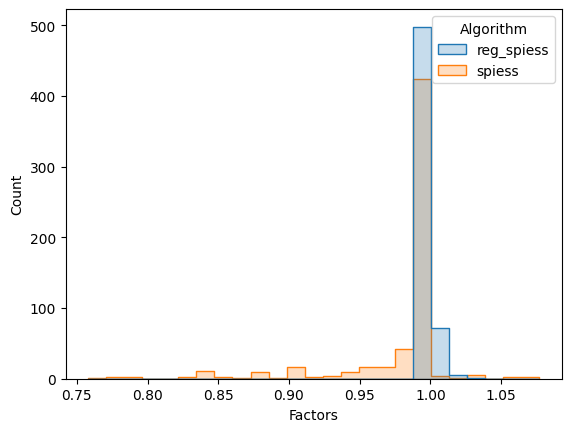

In [34]:
# Reload factors:
cumulative_factors_spiess = all_cumulative[9]
cumulative_factors_rsp = all_cumulative[0]
# Rename columns
cumulative_factors_rsp.rename(columns={'Factors': 'reg_spiess'}, inplace=True)
cumulative_factors_spiess.rename(columns={'Factors': 'spiess'}, inplace=True)
cumulative_factors_rsp.drop('class', axis=1, inplace=True)
cumulative_factors_spiess.drop('class', axis=1, inplace=True)

# Merge data:
merged_cumulative_factors = cumulative_factors_rsp.join(cumulative_factors_spiess)
merged_cumulative_factors = pd.melt(merged_cumulative_factors, var_name='Algorithm', value_name='Factors')

# Create plot
sns.histplot(data=merged_cumulative_factors, x='Factors', bins=25, kde=False, hue='Algorithm', element='step', stat='count')